## Random Forest Regerssor and Result Analysis
- 목적
    - RandomForest API 활용
    - 모델의 예측값 분석

In [21]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import os
from sacred import Experiment
from sacred.observers import FileStorageObserver
from sklearn.ensemble import RandomForestRegressor
import json
from ipywidgets import interact

plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

PROJECT_ID='nycproject-297915' # 여기에 여러분들의 프로젝트 ID를 넣어주세요

In [22]:
ex = Experiment('nyc-demand-prediction', interactive=True)

# experiment_dir가 없으면 폴더 생성하고 FileStorageObserver로 저장
experiment_dir = os.path.join('./', 'experiments')
if not os.path.isdir(experiment_dir): 
    os.makedirs(experiment_dir)
ex.observers.append(FileStorageObserver.create(experiment_dir))

### 전처리

In [23]:
%%time
base_query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
    zip_code,
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    EXTRACT(MONTH FROM pickup_datetime) AS month,
    EXTRACT(DAY FROM pickup_datetime) AS day,
    CAST(format_datetime('%u', pickup_datetime) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_datetime) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend,
    COUNT(*) AS cnt
FROM base_data 
GROUP BY zip_code, pickup_hour, month, day, weekday, hour, is_weekend
ORDER BY pickup_hour
"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id='nycproject-297915')

INFO - pandas_gbq.gbq - Total time taken 8.46 s.
Finished at 2020-12-13 17:21:09.


Wall time: 8.46 s


### 데이터 전처리
- One Hot Encoding이 아닌 Label Encoding

In [24]:
le = LabelEncoder()
base_df['zip_code_le'] = le.fit_transform(base_df['zip_code'])

In [25]:
def split_train_and_test(df, date):
    """
    Dataframe에서 train_df, test_df로 나눠주는 함수
    
    df : 시계열 데이터 프레임
    date : 기준점 날짜
    """
    train_df = df[df['pickup_hour'] < date]
    test_df = df[df['pickup_hour'] >= date]
    return train_df, test_df

### Train / Test 나누기

In [26]:
train_df, test_df = split_train_and_test(base_df, '2015-01-24')

In [27]:
train_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,zip_code_le
65113,10007,2015-01-23 23:00:00,1,23,4,23,0,152,6
65114,11432,2015-01-23 23:00:00,1,23,4,23,0,1,274
65115,11369,2015-01-23 23:00:00,1,23,4,23,0,5,243
65116,11421,2015-01-23 23:00:00,1,23,4,23,0,1,264
65117,10475,2015-01-23 23:00:00,1,23,4,23,0,1,104


- 사용하지 않을 컬럼 삭제

In [28]:
del train_df['zip_code']
del train_df['pickup_hour']
del test_df['zip_code']
del test_df['pickup_hour']

In [29]:
train_df.head(2)

,month,day,weekday,hour,is_weekend,cnt,zip_code_le
0,1,1,3,0,0,37,205
1,1,1,3,0,0,64,5


In [30]:
y_train_raw = train_df.pop('cnt')
y_test_raw = test_df.pop('cnt')

In [31]:
x_train = train_df.copy()
x_test = test_df.copy()

### 모델링

In [32]:
def evaluation(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    score = pd.DataFrame([mape, mae, mse], index=['mape', 'mae', 'mse'], columns=['score']).T
    return score

In [33]:
@ex.config
def config():
    n_estimators=10
    n_jobs=-1

In [34]:
@ex.capture
def get_model(n_estimators, n_jobs):
    return RandomForestRegressor(n_estimators=n_estimators, n_jobs=n_jobs)


In [35]:
@ex.main
def run(_log, _run):
    global rf_reg, rf_pred
    rf_reg = get_model()
    rf_reg.fit(x_train, y_train_raw)
    rf_pred = rf_reg.predict(x_test)
    score = evaluation(y_test_raw, rf_pred)
    
    _run.log_scalar('model_name', rf_reg.__class__.__name__)    
    _run.log_scalar('metrics', score)
    
    return score.to_dict()


In [36]:
import numpy as np
experiment_result = ex.run()

INFO - nyc-demand-prediction - Running command 'run'
INFO - nyc-demand-prediction - Started run with ID "5"
INFO - nyc-demand-prediction - Result: {'mape': {'score': 184.70824643375892}, 'mae': {'score': 35.18639850241987}, 'mse': {'score': 12199.287955894439}}
INFO - nyc-demand-prediction - Completed after 0:00:01


In [37]:
experiment_result.config

{'n_estimators': 10, 'n_jobs': -1, 'seed': 516283744}

In [42]:
def parsing_output(ex_id):
    with open(f'./experiments/{ex_id}/metrics.json') as json_file:
        json_data = json.load(json_file)
    with open(f'./experiments/{ex_id}/config.json') as config_file:
        config_data = json.load(config_file)
    
    output_df = pd.DataFrame(json_data['model_name']['values'], columns=['model_name'], index=['score'])
    output_df['experiment_num'] = ex_id
    output_df['config'] = str(config_data)
    #metric_df = pd.DataFrame(json_data['metrics']['values'][0]['values'])
    print(json_data['metrics']['values'][0]['values'])
    #output_df = pd.concat([output_df, metric_df], axis=1)
    return output_df

In [43]:
parsing_output(5)

mape,mae,mse
184.70824643375892,35.18639850241987,12199.287955894439



,model_name,experiment_num,config
score,RandomForestRegressor,5,"{'n_estimators': 10, 'n_jobs': -1, 'seed': 516..."


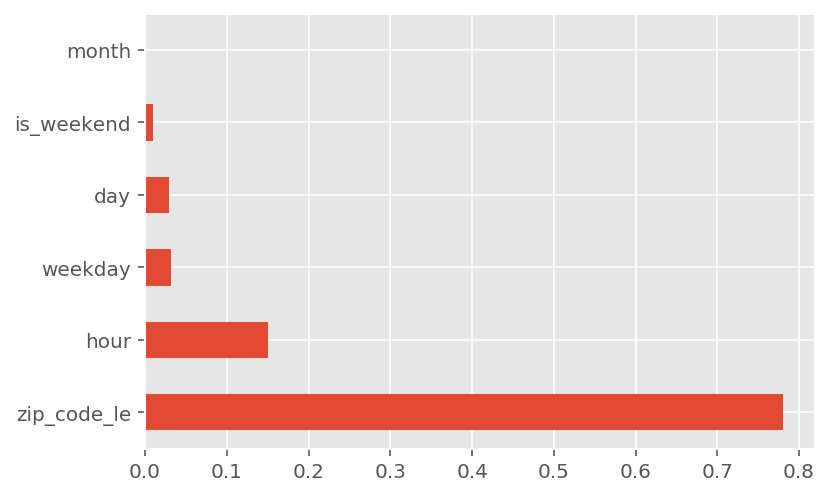

In [44]:
feat_importances = pd.Series(rf_reg.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

### 여전히 zipcode의 중요성이 가장 큼

### 결과 분석

In [45]:
parsing_output(3)

mape,mae,mse
538.5201729610042,57.678736192127054,16512.33021051428



,model_name,experiment_num,config
score,XGBRegressor,3,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."


In [46]:
parsing_output(4)

mape,mae,mse
410.6999624575988,47.991885136076206,13871.771004075945



,model_name,experiment_num,config
score,LGBMRegressor,4,"{'learning_rate': 0.1, 'max_depth': -1, 'n_est..."


In [47]:
parsing_output(5)

mape,mae,mse
184.70824643375892,35.18639850241987,12199.287955894439



,model_name,experiment_num,config
score,RandomForestRegressor,5,"{'n_estimators': 10, 'n_jobs': -1, 'seed': 516..."


### 점점 모델의 성능이 좋아지고 있다

## 그럼 더 자세하게 (feature별)예측이 잘되는지 확인

In [48]:
test_df.head()

,month,day,weekday,hour,is_weekend,zip_code_le
65118,1,24,5,0,1,205
65119,1,24,5,0,1,26
65120,1,24,5,0,1,21
65121,1,24,5,0,1,251
65122,1,24,5,0,1,61


### Data 복구
- Label Encoding, 삭제한 데이터, Datetime 등 다시 reverse encoding

In [49]:
test_df['y_true'] = y_test_raw
test_df['y_pred'] = rf_pred #예측값

In [51]:
test_df['year'] = 2015

In [52]:
test_df.tail()

,month,day,weekday,hour,is_weekend,zip_code_le,y_true,y_pred,year
87015,1,31,5,23,1,17,66,92.7,2015
87016,1,31,5,23,1,186,29,22.3,2015
87017,1,31,5,23,1,38,6,2.4,2015
87018,1,31,5,23,1,55,22,21.1,2015
87019,1,31,5,23,1,7,1166,1175.4,2015


In [53]:
test_df['datetime'] = pd.to_datetime(test_df[['year', 'month', 'day', 'hour']])

INFO - numexpr.utils - NumExpr defaulting to 8 threads.


In [54]:
test_df.tail()

,month,day,weekday,hour,is_weekend,zip_code_le,y_true,y_pred,year,datetime
87015,1,31,5,23,1,17,66,92.7,2015,2015-01-31 23:00:00
87016,1,31,5,23,1,186,29,22.3,2015,2015-01-31 23:00:00
87017,1,31,5,23,1,38,6,2.4,2015,2015-01-31 23:00:00
87018,1,31,5,23,1,55,22,21.1,2015,2015-01-31 23:00:00
87019,1,31,5,23,1,7,1166,1175.4,2015,2015-01-31 23:00:00


In [55]:
test_df['zip_code'] = le.inverse_transform(test_df['zip_code_le'])

In [56]:
test_df.tail()

,month,day,weekday,hour,is_weekend,zip_code_le,y_true,y_pred,year,datetime,zip_code
87015,1,31,5,23,1,17,66,92.7,2015,2015-01-31 23:00:00,10020
87016,1,31,5,23,1,186,29,22.3,2015,2015-01-31 23:00:00,11103
87017,1,31,5,23,1,38,6,2.4,2015,2015-01-31 23:00:00,10044
87018,1,31,5,23,1,55,22,21.1,2015,2015-01-31 23:00:00,10168
87019,1,31,5,23,1,7,1166,1175.4,2015,2015-01-31 23:00:00,10009


In [57]:
test_df = test_df.set_index('datetime')

### Datetime별 차이

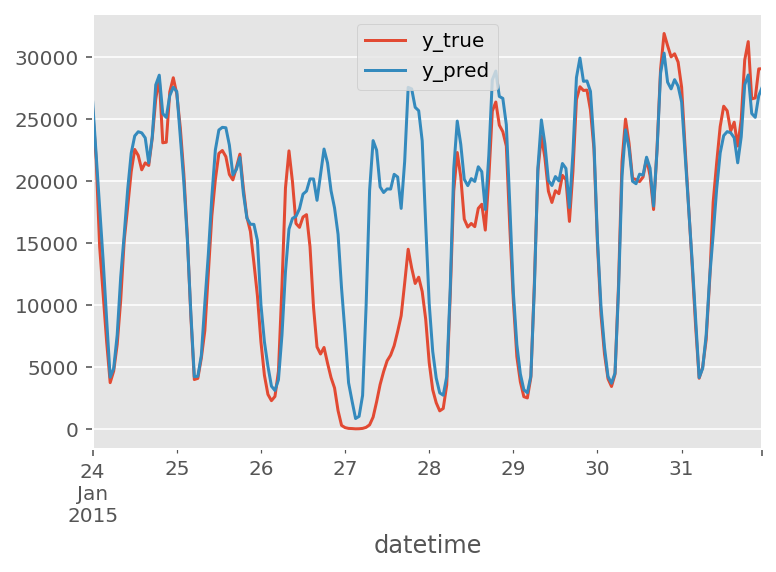

In [60]:
test_df.groupby('datetime').sum()[['y_true', 'y_pred']].plot();
#파랑이 예측값 빨강이 실제값
# 실제값보다 예측이 더 오버하게 되고 있음

### Zip Code별 차이

In [61]:
def visualize_output_by_zipcode(df):
    def view_images(zip_code):
        data = df.loc[df['zip_code'] == str(zip_code)][['y_true', 'y_pred']]
        try:
            ax = data.plot();
            ax.set_title(f'zip_code : {zip_code}')
        except:
            pass
        
    interact(view_images, zip_code=(10001, 10200))

In [62]:
visualize_output_by_zipcode(test_df)

interactive(children=(IntSlider(value=10100, description='zip_code', max=10200, min=10001), Output()), _dom_cl…

### Hour별 차이

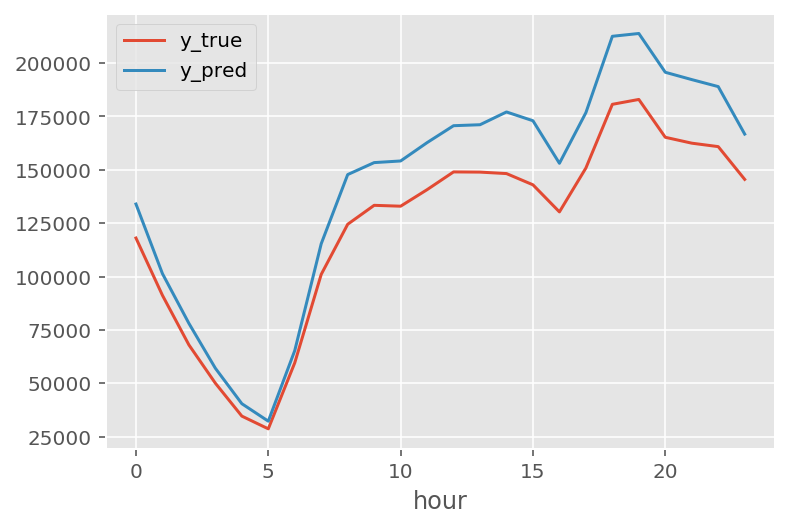

In [63]:
test_df[['hour','y_true', 'y_pred']].groupby('hour').sum()[['y_true', 'y_pred']].plot();

In [64]:
test_df[['hour','y_true', 'y_pred']].groupby('hour').sum()[['y_true', 'y_pred']]

,y_true,y_pred
hour,,
0,118017,133949.3
1,91196,101357.5
2,67973,78051.5
3,50021,57023.0
4,34603,40418.5
5,28638,32218.9
6,59575,65301.2
7,100996,115355.4
8,124475,147748.6


- 새벽 시간엔 거의 유사하다가 7시부터 20시까지 계속 차이가 남

### Weekday별 차이

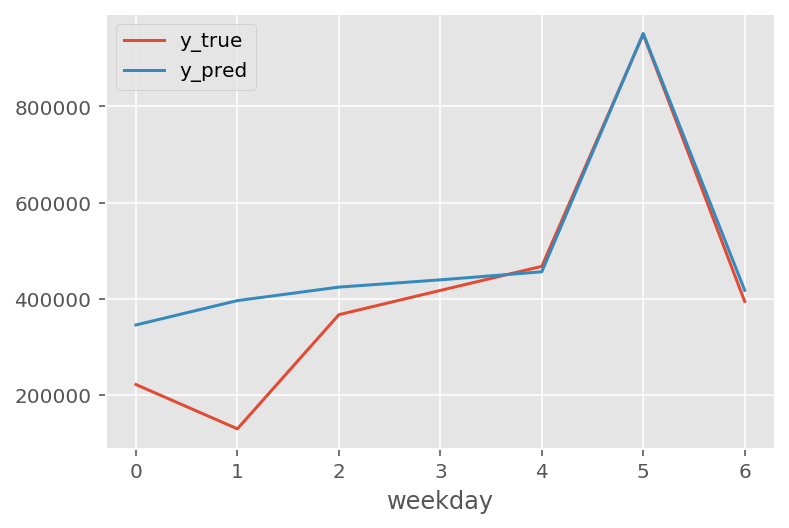

In [66]:
test_df[['weekday','y_true', 'y_pred']].groupby('weekday').sum()[['y_true', 'y_pred']].plot();

- 주말은 대체로 잘 예측하고 월,화,수는 차이가 남
- 눈때문에 떨어진 것 때문에 영향을 준게 아닌가??

### 평일/주말별 차이

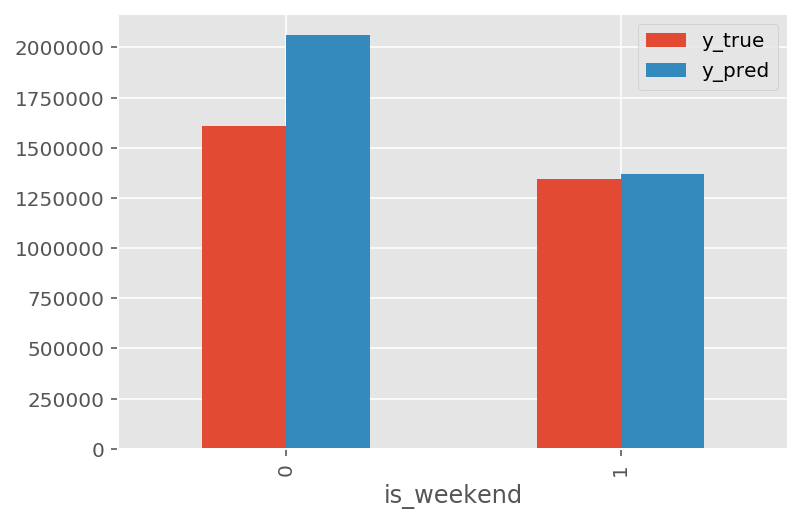

In [68]:
test_df[['is_weekend','y_true', 'y_pred']].groupby('is_weekend').sum()[['y_true', 'y_pred']].plot(kind='bar');

- 평일에 못맞추는 편, 주말에 잘 맞추는 편
    - 평일 중 특히 월화에 격차가 있음